In [0]:
import torch.nn as nn
import librosa
import numpy as np
import torch
import torch.utils.data
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
from torch.autograd import Variable

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

os.chdir('/content/drive/My Drive/Colab Notebooks')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
training_file_path = 'tr/';
file_extension = '.wav'

In [0]:
def get_file_number(number):
    return "0" * (4 - len(number)) + number + file_extension

In [0]:
dirty_files = []
speech_files = []
noise_files = []
for i in range(1200):
    dirty_files.append(training_file_path + 'trx'  + get_file_number(str(i)))
    speech_files.append(training_file_path + 'trs' + get_file_number(str(i)))
    noise_files.append(training_file_path + 'trn' + get_file_number(str(i)))

In [0]:
len(dirty_files)
samples = 50

In [0]:
x_list = np.zeros(shape=(513,1))
s_list = np.zeros(shape=(513,1))
n_list = np.zeros(shape=(513,1))

for i in range(samples):
#     for dirty files
    x, sr=librosa.load(dirty_files[i], sr=None)
    X=librosa.stft(x, n_fft=1024, hop_length=512)
#     for speech files
    s, sr=librosa.load(speech_files[i], sr=None)
    S=librosa.stft(s, n_fft=1024, hop_length=512)
#     for noise files
    n, sr=librosa.load(noise_files[i], sr=None)
    N=librosa.stft(n, n_fft=1024, hop_length=512)

    x_abs = np.abs(X)
    s_abs = np.abs(S)
    n_abs = np.abs(N)
#     x_list.append(x_abs)
#     s_list.append(s_abs)
#     n_list.append(n_abs)
    
#     print(x_abs)
    x_list = np.append(x_list, x_abs, 1)
    s_list = np.append(s_list, s_abs,1)
    n_list = np.append(n_list, n_abs,1)
s_list = s_list.T
n_list = n_list.T
x_list = x_list.T
#     print(x_list)
#     print(x_list.shape)
#     if len(x_list) == 0:
# #       print('inside')
#       x_list = np.transpose(x_abs)
#       s_list = np.transpose(s_abs)
#       n_list = np.transpose(n_abs)
#     else:
#       x_list = np.concatenate((x_list, np.transpose(x_abs)))
#       s_list = np.concatenate((s_list, np.transpose(s_abs)))
#       n_list = np.concatenate((n_list, np.transpose(n_abs)))


In [8]:
print(s_list.shape)

(4311, 513)


In [0]:
def get_IBM(n_list, s_list):
  length = len(s_list)
  ibm_list = np.zeros(shape=(length,513))
  for i in range(length):
    ibm = np.zeros(len(s_list[i]))
    ibm[s_list[i] > n_list[i]] = 1
    ibm_list[i] = ibm
  return ibm_list 
  

In [0]:
y_list = [] 
ibm = get_IBM(n_list, s_list)

In [11]:
print(ibm.shape)
print(x_list.shape)

(4311, 513)
(4311, 513)


In [0]:
ibm = np.expand_dims(ibm, 2)
x_list = np.expand_dims(x_list, 2)

In [13]:
print(ibm.shape)
print(x_list.shape)

(4311, 513, 1)
(4311, 513, 1)


In [0]:

# x_train=[]
# y_train = []
# for i in range(0, samples, 10):
#     x_train_temp = np.array([x_list[i+j] for j in range(10)])
#     y_train_temp = np.array([y_list[i+j] for j in range(10)])
#     if i==0: 
#       x_train = x_train_temp.reshape([x_train_temp.shape[2], 10, 513])
#       y_train = y_train_temp.reshape([y_train_temp.shape[2], 10, 513])
#     else:
#       x_train = np.append(x_train, x_train_temp.reshape([x_train_temp.shape[2], 10, 513]), axis=0)
#       y_train = np.append(y_train, y_train_temp.reshape([y_train_temp.shape[2], 10, 513]), axis=0)

      
# for i in range(0,samples,10):
#   batches = np.array([x_list[i + m] for m in range(10)])
#   batches = batches.reshape([batches.shape[2],10,513]) 
  
#   targets = np.array([target_list[i + t] for t in range(10)])
#   targets = targets.reshape([batches.shape[2],10,513]) 

In [0]:
BATCH = 10
train_loader = torch.utils.data.DataLoader(x_list, batch_size=BATCH)
test_loader = torch.utils.data.DataLoader(ibm, batch_size=BATCH)

In [16]:
#Ref : https://nipunbatra.github.io/blog/2018/denoising.html
class GRU(nn.Module):
  
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()
        self.rnn = nn.GRU(input_size=input_size, hidden_size=hidden_size, 
                          batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        self.act = torch.sigmoid
        
    def forward(self, x):
#         x = x.reshape(10,1, 513)
#         print('input shape')
#         print(x.shape)
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
#         pred = self.act(self.linear(pred))

        return pred
model = GRU(1, 4).cuda()
print(model)

GRU(
  (rnn): GRU(1, 4, batch_first=True)
  (linear): Linear(in_features=4, out_features=1, bias=True)
)


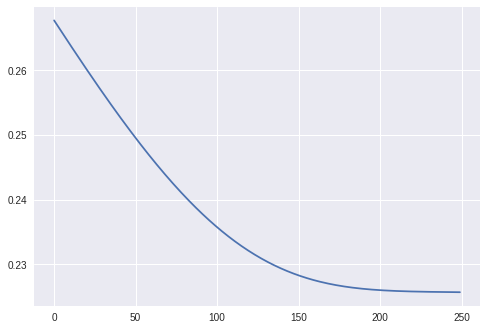

In [17]:

loss_function= nn.MSELoss()
para = model.parameters()
optimizer = torch.optim.Adam(params=para, lr=0.001)
loss_list = []
epochs = 250
train_inp = x_list
train_out = ibm
for i in range(epochs):
#     input_iter = iter(train_loader)
#     target_iter = iter(test_loader)
#     while True:
#         try:
#             input_set = input_iter.next()
#             target_set = target_iter.next()
#             input_set = input_set.cuda()
#             target_set = target_set.cuda()
#             print(input_set.shape)
#             print(target_set.shape)
            
    inp = Variable(torch.Tensor(train_inp.reshape((train_inp.shape[0], -1, 1))), requires_grad=True).cuda()
    out = Variable(torch.Tensor(train_out.reshape((train_out.shape[0], -1, 1))) ).cuda()
    optimizer.zero_grad()
    network_output  = model(inp)
    #             print(network_output.shape)
    #             print(out.shape)
    #             print(target_set[0][0])
    loss = loss_function(network_output , out)
#     print(loss.data)
    loss.backward()
    optimizer.step()
#         except StopIteration:
#             break
    loss_list.append(loss.data.cpu().numpy())
# print(loss.data)
plt.plot(range(epochs), loss_list)
plt.show()      

In [0]:
# doing for one file
x, sr=librosa.load('tr/trx0000.wav', sr=None)
X=librosa.stft(x, n_fft=1024, hop_length=512)
#     for speech files
s, sr=librosa.load('tr/trs0000.wav', sr=None)
S=librosa.stft(s, n_fft=1024, hop_length=512)
#     for noise files
n, sr=librosa.load('tr/trn0000.wav', sr=None)
N=librosa.stft(n, n_fft=1024, hop_length=512)

In [0]:
x_list = np.zeros(shape=(513,1))
s_list = np.zeros(shape=(513,1))
n_list = np.zeros(shape=(513,1))

In [20]:
x_list.shape
x_list[:,0]
print(x_abs.shape)

(513, 92)


In [21]:


x_abs = np.abs(X)
s_abs = np.abs(S)
n_abs = np.abs(N)

print(x_abs.shape)
print(s_abs.shape)
print(n_abs.shape)
    
print(x_list.shape)
if x_list.shape[1] == 1:
  print('here')
  x_list = x_abs
  s_list = s_abs
  n_list = n_abs
else:  
  x_list = np.append(x_list, x_abs,1)
  s_list = np.append(s_list, s_abs,1)
  n_list = np.append(n_list, n_abs,1)

print(x_list.shape)
print(n_list.shape)
print(x_list.shape)

s_list = s_list.T
n_list = n_list.T
x_list = x_list.T



(513, 65)
(513, 65)
(513, 65)
(513, 1)
here
(513, 65)
(513, 65)
(513, 65)


In [22]:
x_list.shape

(65, 513)

In [23]:
x_list = np.expand_dims(x_list, 2)
x_list.shape

(65, 513, 1)

In [24]:
t_inp = Variable(torch.Tensor(x_list.reshape((x_list.shape[0], -1, 1))))
print(t_inp.shape)
pred_t = model(t_inp.cuda())

torch.Size([65, 513, 1])


In [25]:
pred_t.shape

torch.Size([65, 513, 1])

In [0]:
x_abs = torch.Tensor(x_abs)
y = pred_t

In [27]:
print(x_abs.shape)
print(y.shape)
result = np.multiply(x_abs.detach().cpu().numpy().T,y.detach().cpu().numpy().reshape(65,513))
print(result.shape)

torch.Size([513, 65])
torch.Size([65, 513, 1])
(65, 513)


In [0]:
t_inp =  t_inp.detach().numpy()

In [0]:
# t_inp =  t_inp.detach().numpy()
spec = (t_inp.reshape(513,65) / np.abs(t_inp).reshape(513,65)) * result.T
# spec_istft = librosa.istft(spec, hop_length=512)
# print(spec_istft.shape)
# librosa.output.write_wav('validation.wav', spec_istft, sr)

In [30]:
print(spec.shape)

(513, 65)


In [0]:
spec_istft = librosa.istft(spec, hop_length=512)

In [32]:
spec_istft.shape

(32768,)

In [0]:
librosa.output.write_wav('validation2.wav', spec_istft, sr)

In [34]:
ipd.Audio('validation2.wav')

In [54]:
s = np.abs(S).T

print(s.shape)
y = pred_t.reshape(65, 513).detach().cpu().numpy()
print(y.shape)

(65, 513)
(65, 513)


In [57]:
print(10*np.log10(np.sum(np.square(s)/(np.sum(np.square(np.subtract(s ,y)))))))

-6.223246455192566
